# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Walter Thornton and Dwayne Kennemore

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model as lm
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LassoCV
import statsmodels.formula.api as formulas
%matplotlib inline

C:\Users\wlt42\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
#open the files
train_data = pd.read_csv('Bikeshare_train.csv', sep=",", header=0)
test_data = pd.read_csv('Bikeshare_test.csv', sep=",", header=0)

#For a while, we thought a malfunction in our code was being caused by overloading the reserved word "count"
#This turned out not to be the case, but after it was already changed, we just left it.
train_data.rename(index=str, columns={"count": "rentals"}, inplace=True)
test_data.rename(index=str, columns={"count": "rentals"}, inplace=True)
train_data
test_data

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


your answers here

In [3]:
print(train_data.dtypes)
pd.set_option('display.max_rows', 500)
test_data

Unnamed: 0       int64
season         float64
month          float64
holiday        float64
day_of_week    float64
workingday     float64
weather        float64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
rentals        float64
dtype: object


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


Avg rentals on a non-working day:  4461.0733945
Avg rentals on a working day:  4665.8963964


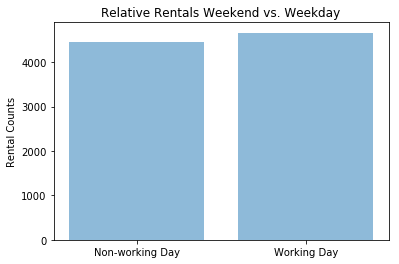

Avg rentals on holiday:  4612.171875
Avg rentals on non-holiday:  4199.18181818


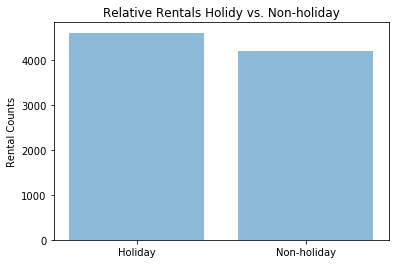

Avg rentals for each season:  [2210.0, 5044.3999999999996, 5680.738636363636, 5602.041666666667]


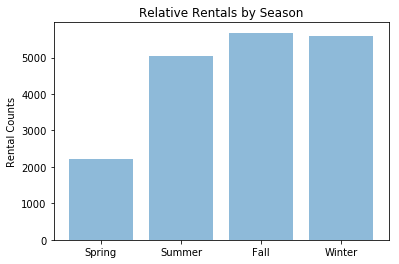

Avg rentals for each type of weather:  [9727.6422018348621, 2096.2783018867926, 1736.2, 0]


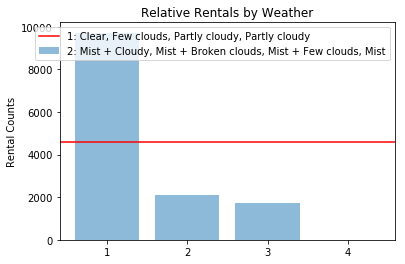

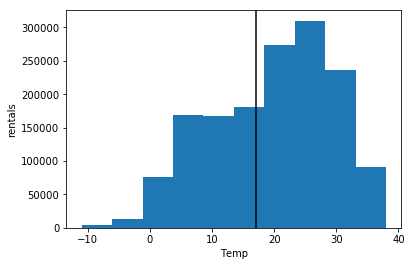

In [4]:
avg = [0, 0]

#Q1. How do the average rentals compare on weekdays vs weekend (training data set)?
#A. The average rentals on a non-working day were 4,461, while average rentals on a working day were
#   4,666. This was unexpected; you'd think that bike rentals would be hiked during the weekend.

objects = ('0', '1')
y_pos = np.arange(len(objects))

day = [train_data.loc[train_data['workingday'] == 0, 'rentals'].sum()]
day.append(train_data.loc[train_data['workingday'] == 1, 'rentals'].sum())
#print("Day = ", day)
number_of_entries = list(pd.value_counts(train_data['workingday'].values, sort=False))
number_of_entries = list(reversed(number_of_entries))
#print("Number of Entries = ", number_of_entries)
avg[0] = day[0] / number_of_entries[0]
avg[1] = day[1] / number_of_entries[1]
print("Avg rentals on a non-working day: ", avg[0])
print("Avg rentals on a working day: ", avg[1])
plt.bar(y_pos, avg, align='center', alpha=0.5)
plt.xticks(y_pos, ['Non-working Day', 'Working Day'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Weekend vs. Weekday')
plt.show()

#Q2. How do bike rentals vary on holidays vs. non-holidays?
#A. Avg rentals on holiday were 4,612 on average, but 4,199 on average for a non-holiday, about 10% different.
objects = ('0', '1')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['holiday'] == 0, 'rentals'].sum()]
day.append(train_data.loc[train_data['holiday'] == 1, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['holiday'].values, sort=False))
avg[0] = day[0] / number_of_entries[0]
avg[1] = day[1] / number_of_entries[1]
print("Avg rentals on holiday: ", avg[0])
print("Avg rentals on non-holiday: ", avg[1])
plt.bar(y_pos, avg, align='center', alpha=0.5)
plt.xticks(y_pos, ['Holiday', 'Non-holiday'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Holidy vs. Non-holiday')
plt.show()

#Q3: How are rentals distributed by season?
#A: Spring has the lowest number, just over 2,000 per day. The other seasons see a multiple of that - on the order of
#5,000 per day (rounded).
avg_2 = [0, 0, 0, 0]
objects = ('1', '2', '3', '4')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['season'] == 1, 'rentals'].sum()]
day.append(train_data.loc[train_data['season'] == 2, 'rentals'].sum())
day.append(train_data.loc[train_data['season'] == 3, 'rentals'].sum())
day.append(train_data.loc[train_data['season'] == 4, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['season'].values, sort=False))
#number_of_entries = list(reversed(number_of_entries))
#print("Number of Entries = ", number_of_entries)
avg_2[0] = day[0] / number_of_entries[0]
avg_2[1] = day[1] / number_of_entries[1]
avg_2[2] = day[2] / number_of_entries[2]
avg_2[3] = day[3] / number_of_entries[3]
print("Avg rentals for each season: ", avg_2)
plt.bar(y_pos, avg_2, align='center', alpha=0.5)
plt.xticks(y_pos, ['Spring', 'Summer', 'Fall', 'Winter'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Season')
plt.show()

#Q4: How are rentals impacted by weather conditions?
#A: Unsurprisingly, rentals are highest when the weather is clear or at worst partly cloudy.
avg_2 = [0, 0, 0, 0]
objects = ('1', '2', '3', '4')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['weather'] == 1, 'rentals'].sum()]
day.append(train_data.loc[train_data['weather'] == 2, 'rentals'].sum())
day.append(train_data.loc[train_data['weather'] == 3, 'rentals'].sum())
day.append(train_data.loc[train_data['weather'] == 4, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['weather'].values, sort=False))
mean = np.mean(train_data['rentals'])
#Note: the try..excepts below are due to the fact that some weather parameters are missing in the data,
#which was creating a division by zero.
try:
    avg_2[0] = day[0] / number_of_entries[0]
except:
    avg_2[0] = 0
try:
    avg_2[1] = day[1] / number_of_entries[1]
except:
    avg_2[1] = 0
try:
    avg_2[2] = day[2] / number_of_entries[2]
except:
    avg_2[2] = 0
try:
    avg_2[3] = day[3] / number_of_entries[3]
except:
    avg_2[3] = 0
print("Avg rentals for each type of weather: ", avg_2)
plt.bar(y_pos, avg_2, align='center', alpha=0.5)
plt.axhline(y=mean, color='r', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Weather')
plt.legend( ('1: Clear, Few clouds, Partly cloudy, Partly cloudy',
             '2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
             '3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
             '4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog') )
plt.show()

#Q5: How are rentals impacted by temperature?
#A: We prepared a histogram to demonstrate this impact. The bulk of rentals occurred when the temperature ranged
#from 20-40. We thought the histogram would be improved if each bar had a low-high range in the x-axis, but we could
#not get this feature to work.
mean = np.mean(train_data['temp'])
plt.hist(train_data['temp'], weights=train_data['rentals'])
plt.axvline(x=mean, color = "black")
plt.ylabel('rentals')
plt.xlabel('Temp')
plt.show()



C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\wlt42\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


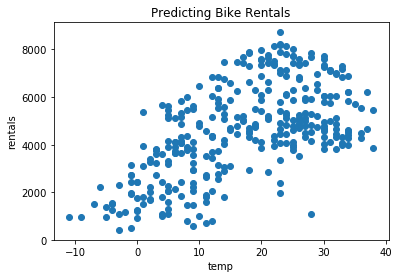

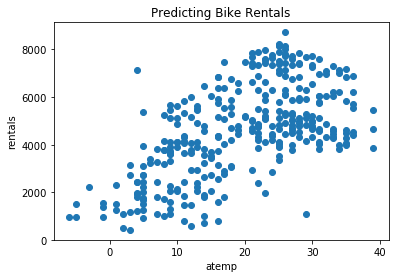

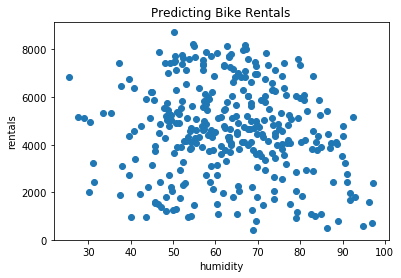

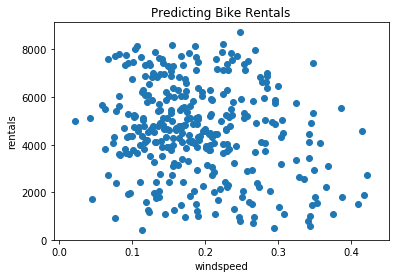

In [5]:

factors = ['temp', 'atemp', 'humidity', 'windspeed']
i = 0
k_list = []
rtrain_list = []
rtest_list = []
for i, k in enumerate(factors):
        
    x = train_data[k]
    x = x.reshape(-1, 1)
    y = train_data['rentals']
    y = y.reshape(-1, 1)
      
    # Build graph
    plt.scatter(x, y)
    plt.xlabel(k)
    plt.ylabel('rentals')
    plt.title('Predicting Bike Rentals')
    plt.show()


In [6]:
#Q6: Do any variables have a clear non linear relationship with rentals.
#A: We tested temp, atemp, humidity and windspeed. Temp and Atemp had a linear relationship, even though it's obviously
#noisy, but humidity and wind speed looked almost *random* in their dispersions. No linear relationship was observable
#in the scatter plots above.

In [7]:
# one hot encoding of test and training set
train_data = pd.get_dummies(train_data, prefix = ['season', 'month', 'day_of_week', 'weather'], columns = ['season', 'month', 'day_of_week', 'weather'], drop_first = True)
test_data = pd.get_dummies(test_data, prefix = ['season', 'month', 'day_of_week', 'weather'], columns = ['season', 'month', 'day_of_week', 'weather'], drop_first = True)

In [8]:
#train_data.columns
#Note: You might well wonder the purpose for the code below. When we put together our
#formulas to run our regressions later here, the code was tripping over the ".0" that
#ends these data items. Neither us nor the TFs in Office Hours could figure out why
#this posed a problem, so we (manually, painstakingly) renamed them all.

train_data.rename(index=str, columns={'season_2.0' : 'season_2'}, inplace=True)
train_data.rename(index=str, columns={'season_3.0' : 'season_3'}, inplace=True)
train_data.rename(index=str, columns={'season_4.0' : 'season_4'}, inplace=True)
train_data.rename(index=str, columns={'month_2.0' : 'month_2'}, inplace=True)
train_data.rename(index=str, columns={'month_3.0' : 'month_3'}, inplace=True)
train_data.rename(index=str, columns={'month_4.0' : 'month_4'}, inplace=True)
train_data.rename(index=str, columns={'month_5.0' : 'month_5'}, inplace=True)
train_data.rename(index=str, columns={'month_6.0' : 'month_6'}, inplace=True)
train_data.rename(index=str, columns={'month_7.0' : 'month_7'}, inplace=True)
train_data.rename(index=str, columns={'month_8.0' : 'month_8'}, inplace=True)
train_data.rename(index=str, columns={'month_9.0' : 'month_9'}, inplace=True)
train_data.rename(index=str, columns={'month_10.0' : 'month_10'}, inplace=True)
train_data.rename(index=str, columns={'month_11.0' : 'month_11'}, inplace=True)
train_data.rename(index=str, columns={'month_12.0' : 'month_12'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_1.0' : 'day_of_week_1'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_2.0' : 'day_of_week_2'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_3.0' : 'day_of_week_3'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_4.0' : 'day_of_week_4'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_5.0' : 'day_of_week_5'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_6.0' : 'day_of_week_6'}, inplace=True)
train_data.rename(index=str, columns={'weather_2.0' : 'weather_2'}, inplace=True)
train_data.rename(index=str, columns={'weather_3.0' : 'weather_3'}, inplace=True)
train_data.columns

test_data.rename(index=str, columns={'season_2.0' : 'season_2'}, inplace=True)
test_data.rename(index=str, columns={'season_3.0' : 'season_3'}, inplace=True)
test_data.rename(index=str, columns={'season_4.0' : 'season_4'}, inplace=True)
test_data.rename(index=str, columns={'month_2.0' : 'month_2'}, inplace=True)
test_data.rename(index=str, columns={'month_3.0' : 'month_3'}, inplace=True)
test_data.rename(index=str, columns={'month_4.0' : 'month_4'}, inplace=True)
test_data.rename(index=str, columns={'month_5.0' : 'month_5'}, inplace=True)
test_data.rename(index=str, columns={'month_6.0' : 'month_6'}, inplace=True)
test_data.rename(index=str, columns={'month_7.0' : 'month_7'}, inplace=True)
test_data.rename(index=str, columns={'month_8.0' : 'month_8'}, inplace=True)
test_data.rename(index=str, columns={'month_9.0' : 'month_9'}, inplace=True)
test_data.rename(index=str, columns={'month_10.0' : 'month_10'}, inplace=True)
test_data.rename(index=str, columns={'month_11.0' : 'month_11'}, inplace=True)
test_data.rename(index=str, columns={'month_12.0' : 'month_12'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_1.0' : 'day_of_week_1'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_2.0' : 'day_of_week_2'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_3.0' : 'day_of_week_3'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_4.0' : 'day_of_week_4'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_5.0' : 'day_of_week_5'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_6.0' : 'day_of_week_6'}, inplace=True)
test_data.rename(index=str, columns={'weather_2.0' : 'weather_2'}, inplace=True)
test_data.rename(index=str, columns={'weather_3.0' : 'weather_3'}, inplace=True)


In [9]:
train_data

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,...,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
0,0,0.0,1.0,24.0,26.0,76.5833,0.118167,6073.0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,2,0.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,0.0,0.0,0.0,4.0,58.6250,0.169779,2431.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,0.0,1.0,23.0,23.0,91.7083,0.097021,1996.0,0,1,...,0,0,0,0,1,0,0,0,0,1
5,5,0.0,1.0,24.0,26.0,69.7083,0.342667,4451.0,1,0,...,0,0,0,1,0,0,0,0,1,0
6,6,0.0,1.0,7.0,11.0,33.3478,0.347835,5315.0,0,0,...,1,0,0,0,0,1,0,0,0,0
7,7,0.0,1.0,23.0,26.0,50.7083,0.269283,4891.0,1,0,...,0,0,0,1,0,0,0,0,0,0
8,8,0.0,0.0,23.0,26.0,50.1667,0.247521,8714.0,0,1,...,0,0,0,0,0,0,0,1,0,0
9,9,0.0,1.0,30.0,30.0,61.9583,0.169771,7347.0,0,1,...,0,0,0,0,1,0,0,0,0,0


We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [10]:
# When using one-hot encoding, for example, for season or month, we omit one month because in the case where seasons 2 - 4 are
# 0, it is implicitly season one, and that is already baked into the numbers (in the alpha coefficient) and doesn't need to be
# explicitly declared. 
#
# We do not include the test set observations in computing mean and SD because we want to reserve that data for providing a
# pure out-of-sample test to ensure our regressions are robust.

In [11]:
train_data.describe()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,...,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,165.000000,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.259819,0.265861,...,0.093656,0.066465,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.329305,0.030211
std,95.695698,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.439199,0.442459,...,0.291790,0.249471,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.171428
min,0.000000,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.500000,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,165.000000,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,247.500000,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,330.000000,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# normalize training data
mean_temp = train_data.temp.dropna().mean()
sd_temp = train_data.temp.dropna().std()
mean_atemp = train_data.atemp.dropna().mean()
sd_atemp = train_data.atemp.dropna().std()
mean_humidity = train_data.humidity.dropna().mean()
sd_humidity = train_data.humidity.dropna().std()
mean_windspeed = train_data.windspeed.dropna().mean()
sd_windspeed = train_data.windspeed.dropna().std()

train_data['temp'] = train_data['temp'].apply(lambda x: (x - mean_temp ) / (sd_temp))
train_data['atemp'] = train_data['atemp'].apply(lambda x: (x - mean_atemp ) / (sd_atemp))
train_data['humidity'] = train_data['humidity'].apply(lambda x: (x - mean_humidity ) / (sd_humidity))
train_data['windspeed'] = train_data['windspeed'].apply(lambda x: (x - mean_windspeed ) / (sd_windspeed))

train_data

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,...,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
0,0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,...,0,0,0,0,1,0,0,0,0,1
5,5,0.0,1.0,0.623798,0.650106,0.441062,1.940601,4451.0,1,0,...,0,0,0,1,0,0,0,0,1,0
6,6,0.0,1.0,-0.895074,-0.860318,-2.095460,2.006654,5315.0,0,0,...,1,0,0,0,0,1,0,0,0,0
7,7,0.0,1.0,0.534453,0.650106,-0.884385,1.002672,4891.0,1,0,...,0,0,0,1,0,0,0,0,0,0
8,8,0.0,0.0,0.534453,0.650106,-0.922167,0.724530,8714.0,0,1,...,0,0,0,0,0,0,0,1,0,0
9,9,0.0,1.0,1.159871,1.052885,-0.099581,-0.269202,7347.0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [13]:
train_data.columns
test_data.columns

Index(['Unnamed: 0', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'rentals', 'season_2', 'season_3', 'season_4', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'weather_2', 'weather_3'],
      dtype='object')

In [14]:
# normalize test data 
test_data['temp'] = test_data['temp'].apply(lambda x: (x - mean_temp ) / (sd_temp))
test_data['atemp'] = test_data['atemp'].apply(lambda x: (x - mean_atemp ) / (sd_atemp))
test_data['humidity'] = test_data['humidity'].apply(lambda x: (x - mean_humidity ) / (sd_humidity))
test_data['windspeed'] = test_data['windspeed'].apply(lambda x: (x - mean_windspeed ) / (sd_windspeed))

In [15]:
y_train = train_data['rentals'].values
X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values

y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values


your answers here

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [16]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

(331, 28) (331, 1) (400, 28) (400, 1)


In [17]:
X_train_lm = X_train
y_train_lm = y_train


lm_1 = LinearRegression(fit_intercept=True)
lm_1.fit(X_train, y_train)

y_pred = lm_1.predict(X_test)

print('The equation of the regression plane is: {} + {}^T . x'.format(lm_1.intercept_, lm_1.coef_))

The equation of the regression plane is: [ 3681.77653152] + [[ -284.35627461   308.15314174   925.73384986   312.43407189
   -548.49294906  -255.12258899   898.82903949  1032.88157484
   1226.18654265    88.94009267   239.18089841   333.34908642
    -65.81249999  -792.2628985  -1279.98700626  -776.4754899    405.1445661
    486.25090367   112.68164522  -118.83581872  -123.75147639
   -195.28593262   170.51134687    61.25602987   111.06689939
    465.14500996   -16.56658402 -1581.97828361]]^T . x


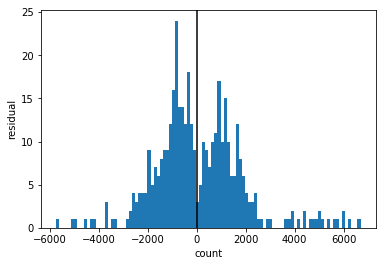

In [20]:
# Residual plot
plt.hist(y_test - y_pred, bins=100)
plt.axvline(x=0, color = "black")
plt.ylabel('residual')
plt.xlabel('count')
plt.show()

In [ ]:
# The only factor that seems to have a positive corrleation with rentals (which doesn't have a p value rendering it
# statistically insignificant), is factor 9, which is the season 4 (winter) flag. 

# Day of the week, month, and holiday seem to have no relationship to rentals.

# CAUTION: The values here were computed with a number of factors that need to be removed due to colinearity and we do NOT
# consider the current relationships, as observed, reliable.

# The coefficients for temp and atemp are different nominally, as shown below:
# x3           925.7338    474.536      1.951      0.052      -8.070    1859.538
# x4           312.4341    429.987      0.727      0.468    -533.705    1158.573
# One is 926 and the other is 312, as can be seen, but in a statistical sense they aren't *really* different because
# we cannot say they are reliably different from zero (i.e., the variation observed might be noise.)

In [ ]:
train_MSE= np.mean((y_train - lm_1.predict(X_train))**2)
test_MSE= np.mean((y_test - lm_1.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm_1.score(X_train, y_train)
test_R_sq = lm_1.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

In [ ]:
# statsmodel regression
# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
# build the OLS model from the training data
smm = sm.OLS(y_train, X)

#save regression info in results_sm
results_sm = smm.fit()

print(results_sm)


In [ ]:
print(results_sm.summary())
print('Parameters: ', results_sm.params)


your answers here

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [ ]:
print(train_data.head())
dimensions = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
    'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
    'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
    'weather_3']
corr_matrix = np.corrcoef(train_data[dimensions].T)
for y in range(0, len(corr_matrix)):
    for x in range(0, len(corr_matrix)):
        print ("%5.2f " % corr_matrix[y][x], end="")
    print()
heatmap = plt.pcolor(corr_matrix, cmap=matplotlib.cm.Blues)
plt.show()

dimensions_2 = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'month_2', 'month_3', 'month_4', 'month_5', 
    'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
    'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
    'weather_3']
corr_matrix_2 = np.corrcoef(train_data[dimensions_2].T)
for y in range(0, len(corr_matrix_2)):
    for x in range(0, len(corr_matrix_2)):
        print ("%5.2f " % corr_matrix_2[y][x], end="")
    print()
heatmap_2 = plt.pcolor(corr_matrix_2, cmap=matplotlib.cm.Blues)
plt.show()

'''
The first heatmap provided above does reflect correlation concentrations that
suggest colinearity. They have been removed in the second.

Atemp and the seasons have been removed. Atemp should correlate highly with temp and
the months all neatly bucket within the seasons; there's no good reason to have both.
'''

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [ ]:
dimensions_3 = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'season_2', 'season_3', 'season_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 'weather_3']
y = train_data.rentals
X = train_data[dimensions_3]

# We'll use a slightly narrower feature set going into the stepwise algorithm, 
# having pruned the months and atemp due to covariance

In [ ]:
# step forward model selection
# gets the bic of a given model, creates dict entry of model with its bic
def get_bic(predictors):
    model = sm.OLS(y, X[list(predictors)]).fit()
    return {"model": model, "bic" : model.bic}

# determine the best of a given set of models
def best_of(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(get_bic(predictors+[p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models['bic'].argmin()]
    return best_model

models = pd.DataFrame(columns=["bic", "model"])
predictors = []

# go through predictors stepwise until adding more predictors raises bic
for i in range(1, len(X.columns)+1):
    models.loc[i] = best_of(predictors) 
    predictors = models.loc[i]["model"].model.exog_names
    if i == 1:
        best_score = models.loc[i]["bic"]        
    else:
        if models.loc[i]["bic"] < best_score:
            best_score = models.loc[i]["bic"]        
        if models.loc[i]["bic"] > best_score:
            best_model = models.loc[i-1]
            print(best_model)
            break

            

In [ ]:
print(best_model[1].summary())

# save model for further use in cross-validation
forward_step_model = best_model[1]

In [ ]:
dimensions_4 = ['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']

In [ ]:
X_train = train_data[['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']].values

X_test = test_data[['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']].values


lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)


In [ ]:
train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

This process dramatically reduced the number of predictors to around 10 with similar performance. Ising the correlation matrix and stewise selection, we were able to eliminate much of the colinearity.The performance on the training set is about the same as the earlier models with more predictores. Although the r2 score was lower for the training data with the simpler model. Despite all this improvement in the complexity of the model, the result hint that maybe a linear model is not the best choice.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [ ]:
# our models - lm_1 all predictors
#              lm   pruned predictors

# first model
scores = cross_val_score(lm, X_train_lm, y_train_lm, cv=10)
lm_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_avg)
print



your answers here

In [ ]:
# second model
scores = cross_val_score(lm_1, X_train, y_train, cv=10)
lm_1_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_1_avg)

In the second model we have a higher average score, inline with its earlier outperforming of the first model.